#  Let the Tensors Board?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("drive/MyDrive/Colab Notebooks/IDL")

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import MNISTDataset
%load_ext tensorboard
from datetime import datetime

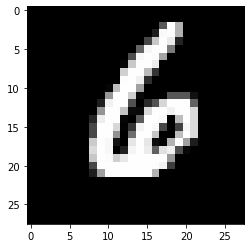

6


In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# we can look at any of the images and the corresponding labels
# say, image no. 155
plt.imshow(train_images[155], cmap="Greys_r")
plt.show()
print(train_labels[155])

train_images = (train_images.astype(np.float32) / 255.).reshape((-1, 784))
test_images = (test_images.astype(np.float32) / 255.).reshape((-1, 784))

train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)




In [ ]:
# 60000 elements in the training set
print(train_images.shape, train_labels.shape)

(60000, 784) (60000,)


# Multi Layer Perceptron

## Handling Dynamic Layers and Activation Functions



*   **init_params()** Initializes all the weights and biases 
*   **forward_propogation()** computes return the outputs given W and b
*   **backwardpass()** computes the gradient based on the error from the forward pass
















In [ ]:

def init_params(minval,maxval,num_layers):
  params = {}
  for i in range(len(num_layers)-1):
    params["w_h"+str(i)] = tf.Variable(tf.random.uniform([num_layers[i],num_layers[i+1]],minval=minval,maxval=maxval))
    params["b_h"+str(i)] = tf.Variable(tf.random.uniform([num_layers[i+1]],minval=minval,maxval=maxval))

  return params

In [ ]:
def apply_activation_functions(activation_fn,x):
  if activation_fn=="sigmoid":
    return tf.nn.sigmoid(x)
  elif activation_fn=="relu":
    return tf.nn.relu(x)
  elif activation_fn=="tanh":
    return tf.nn.tanh(x)


In [ ]:
def forward_propogation(inputs,num_layers,params,activation_fn):

  '''
  inputs = image_batch
  num_layers = size of the layers inlcuding i/p and o/p
  params = weights and biases of num_layers-1
  activation_fn = 
  '''

  layer_outputs = {}
  for i in range(num_layers-1):
    if i==0: #input
      layer_outputs["h_"+str(i)]= tf.add(tf.matmul(inputs,params["w_h"+str(i)]),params["b_h"+str(i)])
      layer_outputs["h_"+str(i)] = apply_activation_functions(activation_fn,layer_outputs["h_"+str(i)])
    elif (i>0) and (i!=num_layers-2): # hidden

      layer_outputs["h_"+str(i)]= tf.add(tf.matmul(layer_outputs["h_"+str(i-1)],params["w_h"+str(i)]),params["b_h"+str(i)])
      layer_outputs["h_"+str(i)] = apply_activation_functions(activation_fn,layer_outputs["h_"+str(i)])

    elif i==num_layers-2:#output
      layer_outputs["output"]= tf.add(tf.matmul(layer_outputs["h_"+str(i-1)],params["w_h"+str(i)]),params["b_h"+str(i)])

  return layer_outputs["output"]

In [ ]:
def backward_pass(image_batch,label_batch,learning_rate,num_layers,params,activation_fn):
  '''
  image_batch = image_batch
  label_batch = label_batch
  learning_rate = learning rate
  num_layers = from forward pass
  params = from forward pass
  activation_fn = name of the activation function
  '''
  with tf.GradientTape() as tape:
    logits = forward_propogation(inputs=image_batch,num_layers=num_layers,params=params,activation_fn=activation_fn)
    xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=label_batch))
    grads = tape.gradient(xent,list(params.values()))

    for i in range(0,len(grads),2):
      params["w_h"+str(i//2)].assign_sub(learning_rate * grads[i])
      params["b_h"+str(i//2)].assign_sub(learning_rate * grads[i+1])
    return logits, xent, params
    

In [ ]:

def train_model(train_data,train_steps,learning_rate,num_layers,param_list,activation_fn,log_name):

  logdir = os.path.join("logs", log_name + str(datetime.now()))
  train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))
  test_writer = tf.summary.create_file_writer(os.path.join(logdir, "test"))
  params = param_list
  batch_loss_over_iter = []
  acc_over_iter = []
  step = 0
  while step<=train_steps:
    for image_batch, label_batch in train_data:
      
      if step>train_steps:
        break
      step+=1
      logits, xent, params = backward_pass(image_batch,label_batch,learning_rate,len(num_layers),params,activation_fn)
      preds = tf.argmax(logits, axis=1, output_type=tf.int32)
      acc = tf.reduce_mean(tf.cast(tf.equal(preds, label_batch),
                              tf.float32))

      if not step % 10:
        
        test_logits = forward_propogation(inputs=test_images,num_layers=len(num_layers),params=params,activation_fn=activation_fn)
        test_preds = tf.argmax(test_logits, axis=1, output_type=tf.int32)
        test_acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, test_labels),
                             tf.float32))
        # batch_loss_over_iter.append(xent.numpy())
        # acc_over_iter.append(acc.numpy())
       
        with train_writer.as_default():
          tf.summary.scalar("accuracy",acc,step=step)
          tf.summary.histogram("logits", logits, step=step)
          tf.summary.histogram("weights_input", params["w_h0"], step=step)
          tf.summary.image("input", tf.reshape(image_batch, [-1, 28, 28, 1]), step=step)

        with test_writer.as_default():
          tf.summary.scalar("accuracy",test_acc,step=step)
      
      if not step % 1000:
          print("Step {}. Batch loss: {} Batch accuracy: {}".format(step+1, xent, acc))
  return params, batch_loss_over_iter, acc_over_iter


# Shuffle Batch Repeat

In [ ]:
# training loop
train_steps = 2000
learning_rate = 0.1
num_layers=[784,256,10]
params = init_params(-0.1,0.1,num_layers)
activation_fn = "sigmoid"

train_data_ = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

print("Shuffle-Batch-Repeat")
train_data = train_data_.shuffle(60000).batch(128).repeat(3)
updated_params, _ , _ = train_model(train_data, train_steps,learning_rate,num_layers,params,activation_fn,"Shuffle-Batch-Repeat")

print("Shuffle-Repeat-Batch")
train_data = train_data_.shuffle(60000).repeat(3).batch(128)
updated_params, _ , _ = train_model(train_data, train_steps,learning_rate,num_layers,params,activation_fn,"Shuffle-Repeat-Batch")

print("Batch-Repeat-Shuffle")
train_data = train_data_.batch(128).repeat(3).shuffle(60000)
updated_params, _ , _ = train_model(train_data, train_steps,learning_rate,num_layers,params,activation_fn,"Batch-Repeat-Shuffle")

print("Batch-Shuffle-Repeat")
train_data = train_data_.batch(128).shuffle(60000).repeat(3)
updated_params, _ , _ = train_model(train_data, train_steps,learning_rate,num_layers,params,activation_fn,"Batch-Shuffle-Repeat")

print("Repeat-Shuffle-Batch")
train_data = train_data_.repeat(3).shuffle(60000).batch(128)
updated_params, _ , _ = train_model(train_data, train_steps,learning_rate,num_layers,params,activation_fn,"Repeat-Shuffle-Batch")

print("Repeat-Batch-Shuffle")
train_data = train_data_.repeat(3).batch(128).shuffle(60000)
updated_params, _ , _ = train_model(train_data, train_steps,learning_rate,num_layers,params,activation_fn,"Repeat-Batch-Shuffle")

Shuffle-Batch-Repeat
Step 1001. Batch loss: 0.384280264377594 Batch accuracy: 0.921875
Step 2001. Batch loss: 0.4040263891220093 Batch accuracy: 0.890625
Shuffle-Repeat-Batch
Step 1001. Batch loss: 0.3100601136684418 Batch accuracy: 0.8984375
Step 2001. Batch loss: 0.12054286152124405 Batch accuracy: 0.9609375
Batch-Repeat-Shuffle
Step 1001. Batch loss: 0.5125271081924438 Batch accuracy: 0.90625
Step 2001. Batch loss: 0.08836393058300018 Batch accuracy: 0.984375
Batch-Shuffle-Repeat
Step 1001. Batch loss: 0.11751774698495865 Batch accuracy: 0.984375
Step 2001. Batch loss: 0.1616492122411728 Batch accuracy: 0.9609375
Repeat-Shuffle-Batch
Step 1001. Batch loss: 0.12077663838863373 Batch accuracy: 0.96875
Step 2001. Batch loss: 0.21420961618423462 Batch accuracy: 0.9296875
Repeat-Batch-Shuffle
Step 1001. Batch loss: 0.35467761754989624 Batch accuracy: 0.8984375
Step 2001. Batch loss: 0.2652748227119446 Batch accuracy: 0.9453125


The shuffle method uses a fixed-size buffer to shuffle the items as they pass through. Setting a buffer_size greater than the number of examples in the Dataset ensures that the data is completely shuffled. Batch is used the group the instances into batches and repeat repeates the instances for a specified number of epoches (if specified).


## Batch-Repeat-Shuffle
This combination creates batches based on the order of the input data, and then repeats the same batches n(count) times. The order of the batches are then shuffled lastly.
## Batch-Shuffle-Repeat
This combination creates batches based on the order of the input data, and shuffles the order of the batches randomly. Lastly; The shuffled batches are then repeated n(count) times.
## Shuffle-Batch-Repeat
This combination shuffles the input data randommly firstly. Then it creates batches based on the shuffled data. Lastly The batches are then repeated n(count) times.
## Repeat-Batch-Shuffle
This combination repeats the input data firstly. Then it creates batches based on the repeated input data data. Lastly The batches are then shuffled randomly.

## Shuffle-Repeat-Batch
This combination shuffles the input data. Then it repeats the shuffling data n(count) times. Lastly it creates batches of a defined batch_size. This is theoretically better than the combinations above but still can be biased on the initial shuffle.

## Repeat-Shuffle-Batch
This combination repeats the input data n(count) times. Then it shuffles the repeated input data randomly data n(count) times. Lastly it creates batches of a defined batch_size based on the shuffled, repeated data.

## Conclusion 
It was agreed that the batching should be the last step while training the neural network.This is due to the fact that the batch composition should be different and well distributed for the classes available in the dataset, and this would not be possible if input data was biased.   

Repeat-shuffle-batch was agreed to be the winner as the batch composition would be most varied. The order of input instance is arbitrary for each batch and not repeated for any other batch in the dataset.

In [ ]:
#%tensorboard --logdir logs

# Fail Scripts

# fail 1
Loss is nan. Gradient blow up

1. Changing the number of layers in the network to 1 seem to improve the accuracy to ~97%. 
2.  changing the weights to 0.1 resolves the exploding of gradients

# fail 2

1. Changing the number of layers in the network to 2 seem to improve the accuracy to ~97%. The reason could be that the gradients are vanishing.  
2. Increasing the weight range to 1 increases the **accuracy**
3. Changing the activation function to relu works maybe becasue the values provided to the sigmoid is so small that it gets saturated.

# fail 3

1. Changing the range of weights seems to increase the accuracy 
2. Relu resticts the weights to positive but we have weights from [-0.1,0]. So changing the activation to leaklyRELU or sigmoid with a higher learnign rate solves the problem. since the weights range lie between [0, -0.1] the RELU outputs 0, and technically there is no learning process and the remains same.


# fail 4

1. Changing the stddev of noise to 0.1 worked. The image is too noisy to learn and hence the training accuracy is very low. Too little noise or too much noise, both extremes are probably not a good idea

```
img_batch += tf.random.normal(tf.shape(img_batch), stddev=0.1)
```




# fail 5

we are technically applying softmax on top of softmax which will lead to incorrect results. From my understanding, I think the highest probability label will remain the same. But it could be that the error/loss differs. (may be the number of steps required to converge might be more)